<center><h1 style="font-size:40px;">Exercise III:<br> Image Classification using CNNs</h1></center>

---

Welcome to the *fourth* lab for Deep Learning!

In this lab an CNN network to classify RGB images. Image classification refers to classify classes from images. This labs the *dataset* consist of multiple images where each image have a target label for classification.

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!


Good luck!

---

# Import packages

In [1]:
#!pip install pycocotools-windows

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to acces the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('')))

In [2]:
# Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# local modules
from torch.utils.data import DataLoader
from utils.progressbar import LitProgressBar
from utils.dataset import ClassificationDataset
from utils.model import Model
from config import LabConfig
from collections import OrderedDict
from utils import plot
import pprint
import torchmetrics
import pytorch_lightning as pl
import torchvision

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

/opt/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


# Load config

In [3]:
cfg = LabConfig()
cfg.todict()

{'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'fineGrained': False,
 'NUM_CLASSES': 4,
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation',
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'SEED': 420,
 'GPU': 0,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'TENSORBORD_DIR': 'logs/'}

# Example Task
First we present an example task to get an idea of the implementation and how to structure the code.

## Example data
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at the [pytorch doc](https://pytorch.org/vision/stable/transforms.html)

Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader.

### Augmentation

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), 
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), #, 
])

In [5]:
train_transform

Compose(
    ToTensor()
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
)

### Create dataloaders

In [6]:
train_dataloader = DataLoader(ClassificationDataset(cfg.training_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(ClassificationDataset(cfg.validation_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

test_dataloader = DataLoader(ClassificationDataset(cfg.testing_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we visualise the data. 

x (32, 3, 128, 128) torch.float32 0.0 1.0
y (32,) torch.int64 0 2


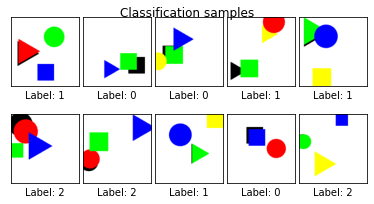

In [7]:
t_x, t_y = next(iter(train_dataloader))
print(f"x {tuple(t_x.shape)} {t_x.dtype} {t_x.min()} {t_x.max()}")
print(f"y {tuple(t_y.shape)} {t_y.dtype} {t_y.min()} {t_y.max()}")
plot.Classification.data(t_x, t_y, nimages=10,nrows=2)

In [8]:
if False: # Set to true to visualise statistics of the data
    plot.show_statistics(cfg.training_img_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
    plot.show_statistics(cfg.validation_img_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
    plot.show_statistics(cfg.testing_img_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")

## Create model
Here is an simple architecture to train our network.

In [9]:
class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        
        self.fc1 = nn.Linear(64*input_shape[1]//4*input_shape[1]//4, 64) # Calculated with the size. why //4
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1

        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
       
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

## Config

In [10]:
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

## Train

In [11]:
# Load model
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

/home/stud/j/johagg17/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
/home/stud/j/johagg17/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stud/j/johagg17/.local/lib/python3.8/site-packages/pytorch_lig

/home/stud/j/johagg17/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1805: LightningDeprecationWarning: `trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7. Use `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(


## Test the network on the test dataset
To test the performance for a qualitative estimation we can plot the input, target and the models prediction. This is a good approach to see the performance and understand if the model is close to a correct decision. However, for big data, we probobly want to focus on a qualitative estimation. Therefore we can analyse **Tensorboard** logs to get a better understanding of the model.

In [40]:
# Create iterable from the test dataset
iter_dataloader = iter(test_dataloader)

In [41]:
# Take one batch from the test dataset and predict!
X, Y = next(iter_dataloader)
preds = torch.argmax(modelObj.predict_step(X,0,0),dim=1)

In [42]:
n_test = 10
df_result = pd.DataFrame({
    'Ground Truth': Y[:n_test],
    'Predicted label': preds[:n_test]})
display(df_result.T)

,0,1,2,3,4,5,6,7,8,9
Ground Truth,1,2,1,2,2,1,1,0,1,0
Predicted label,1,2,0,0,1,1,0,2,1,0


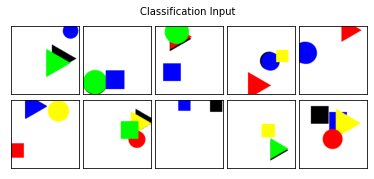

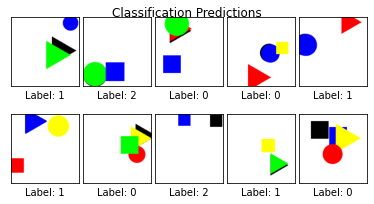

In [43]:
plot.Classification.results(X, preds)

# Exercises

## Metrics
**TODO:** Does a high accuracy impy a good model, motivate your answer.

**TODO:** Find an alternative metric which can show similar or better precision than accuracy.

### Accuracy

#### Training

In [50]:
iter_train_dataloader = iter(train_dataloader)
X_t, Y_t = next(iter_train_dataloader)

train_preds = torch.argmax(modelObj.predict_step(X_t,0,0),dim=1)
print("Train accuracy {}%".format(np.mean(Y_t.numpy() == train_preds.numpy())*100))

Train accuracy 100.0%


#### Test

In [55]:
iter_dataloader = iter(test_dataloader)
X, Y = next(iter_dataloader)
preds = torch.argmax(modelObj.predict_step(X,0,0),dim=1)
print("Test accuracy {}%".format(np.mean(Y.numpy() == preds.numpy())*100))

Test accuracy 59.375%


### Precision

In [58]:
from torchmetrics import Precision
precision = Precision(average='macro', num_classes=cfg.todict()['NUM_CLASSES'])

#### Training

In [59]:
precision(train_preds, Y_t)

tensor(1.)

#### Test

In [60]:
precision(preds, Y)

tensor(0.4476)

### Comparison between metrics, using tensorboard

#### Config

In [150]:
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.Precision(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.AUROC(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.Precision(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.AUROC(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

/home/stud/j/johagg17/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


#### Train

In [64]:
# Load model
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )

trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stud/j/johagg17/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


## Architecture
Modify the architecture of the SimpleModel to further increase the performance. Remember that very deep network allow the network to learn many features but if the dataset is to small the model will underfit. A simple dataset should not require a very deep network to learn good features.

**TODO:** Modify the SimpleModel architecture. Force the network to overfit. How bad performance can you get from the network?

**TODO:** Modify the SimpleModel and increase the complexity a little. Does the performance improve? If not, did you modify it to much or to little?

**TODO:** Modify the SimpleModel architecture. Now combine the hyperparameter tuning and modification of the architecture to reach a performance that is close to the truth images. Explain in detail why the change was applied and if it improved the model a lot.

### The model

In [12]:
class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        conv_layers = 3
        self.conv_layer1 = self._conv_layer_set(num_channels, 24) # 2
        self.conv_layer2 = self._conv_layer_set(24, 24) # 4
        self.conv_layer3 = self._conv_layer_set(24, 40)
        
                
        ## Look up how width and height should change between convolutional layers. 
        
        self.fc1 = nn.Linear(40*input_shape[1]//np.power(2, conv_layers)*input_shape[1]//np.power(2, conv_layers), 64) # Calculated with the size. why //4
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1
        
        
        out = self.conv_layer1(x)      
        out = self.conv_layer2(out)
        out = self.conv_layer3(out) 
        
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)
        
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
                               
        
        return out

### Config

In [13]:
# Train model
config = {
    'drop':0.5,
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.007,
            'weight_decay':0
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        #torchmetrics.Precision(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        #torchmetrics.AUROC(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        #torchmetrics.Precision(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        #torchmetrics.AUROC(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

In [14]:
def train():
    # Load model
    modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)
     
    # Setup trainer
    trainer = pl.Trainer(
                max_epochs=config['max_epochs'], 
                gpus=1,
                logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
                callbacks=[pl.callbacks.progress.TQDMProgressBar()],
                progress_bar_refresh_rate=1,
                weights_summary=None, # Can be None, top or full
                num_sanity_val_steps=10,   
            )

    trainer.fit(
        modelObj, 
        train_dataloader=train_dataloader,
        val_dataloaders=valid_dataloader
    );

### Todo1
**Version 17 in tensorboard logs**, removed dropout since it purpose is to introduce regularization. Ran for 40 epochs. 

In [27]:
config['max_epochs'] = 40
train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


### Todo2

In [62]:
config['max_epochs'] = 5
train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


### Todo3

## Hyperparameter tuning
### Task 1
From the example approach we can see that the network performed very poorly. For the network to be consider "good" the truth images should match the predicted images. If the architecture can learn but is unstable (check loss/epoch in tensorboard), it is possible to tune the parameters of the network. This mostly involves changing the learning rate, optimizers, loss function etc. to better learn features. A network that have a to high learning rate create a increase in variance of the network weights which can make the network unstable.


**TODO:** Perform hyperparameter tuning. Explain in detail why the parameters was changed and why it is considered "better".

### Todo1

In [16]:
class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        nr_conv_layers = 3
        
        conv_layers = []
        self.conv_layer1 = self._conv_layer_set(num_channels, 32) # 2 
        self.conv_layer2 = self._conv_layer_set(32, 128) # 4 128
        self.conv_layer3 = self._conv_layer_set(128, 150) # 128 (in)
        conv_layers.extend([self.conv_layer1, self.conv_layer2, self.conv_layer3]) #, self.conv_layer4])
        
        self.convolve = nn.Sequential(*conv_layers)
        
        print(self.convolve)
        
        
        feedforward = []
        
        self.fc1 = nn.Linear(150*input_shape[1]//np.power(2, nr_conv_layers)*input_shape[1]//np.power(2, nr_conv_layers), 150) # Calculated with the size. why //4
        self.fc2 = nn.Linear(150, num_classes)
        self.drop = nn.Dropout(0.8)
        
        
        feedforward.append(self.fc1)
        feedforward.append(self.drop)
        feedforward.append(self.fc2)
            
        
        self.ffd = nn.Sequential(*feedforward)
        print(self.ffd)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1
        
        out = self.convolve(x)
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)
        
        out = self.ffd(out)
        
        return out

In [18]:
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config) 
# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[pl.callbacks.progress.TQDMProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )

trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

/home/stud/j/johagg17/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
/home/stud/j/johagg17/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stud/j/johagg17/.local/lib/python3.8/site-packages/pytorch_ligh

Sequential(
  (0): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (conv): Conv2d(128, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
Sequential(
  (0): Linear(in_features=38400, out_features=150, bias=True)
  (1): Dropout(p=0.8, inplace=False)
  (2): Linear(in_features=150, out_features=4, bias=True)
)


In [43]:
iter_dataloader = iter(test_dataloader)

In [44]:
X, Y = next(iter_dataloader)
preds = torch.argmax(modelObj.predict_step(X,0,0),dim=1)
print("Test accuracy {}%".format(np.mean(Y.numpy() == preds.numpy())*100))

Test accuracy 93.75%


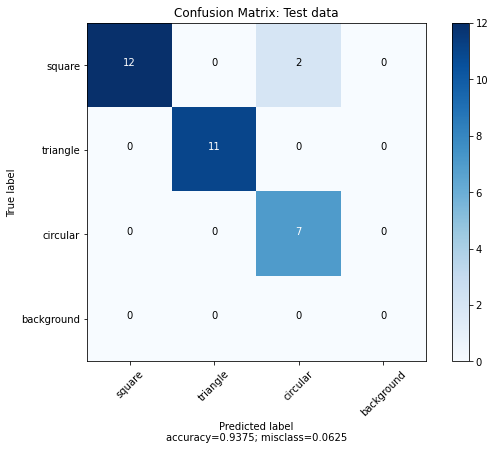

In [45]:
confuTst = torchmetrics.functional.confusion_matrix(preds.detach().cpu(),Y.int().detach().cpu(), cfg.NUM_CLASSES)

plot.confusion_matrix(cm = confuTst.numpy(), 
                      normalize = False,
                      target_names = cfg.CLASSES,
                      title = "Confusion Matrix: Test data")

## Augmentation
**TODO:** Test if data augmentation help. Note that if we want to apply augmentation we need to make sure that the input and target perform the same augmentation. Otherwise, the data will not be correct!

In [63]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(0.3),
    #torchvision.transforms.RandomVerticalFlip(),
    #torchvision.transforms.RandomRotation(15),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), 
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
  #  torchvision.transforms.RandomHorizontalFlip(0.3),
    #torchvision.transforms.RandomVerticalFlip(),
    #torchvision.transforms.RandomRotation(15),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), #, 
])

train_transform

Compose(
    ToTensor()
    RandomHorizontalFlip(p=0.3)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
)

In [64]:
train_dataloader = DataLoader(ClassificationDataset(cfg.training_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(ClassificationDataset(cfg.validation_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

test_dataloader = DataLoader(ClassificationDataset(cfg.testing_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

In [65]:
#config['conv_out1'], config['conv_out2'], config['conv_out3'] = (32, 64, 128)
#config['max_epochs'] = 20
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config) 
# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[pl.callbacks.progress.TQDMProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )

trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sequential(
  (0): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (conv): Conv2d(128, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
Sequential(
  (0): Linear(in_features=38400, out_features=150, bias=True)
  (1): Dropout(p=0.8, inplace=False)
  (2): Linear(in_features=150, out_features=4, bias=True)
)


Test accuracy 96.875%


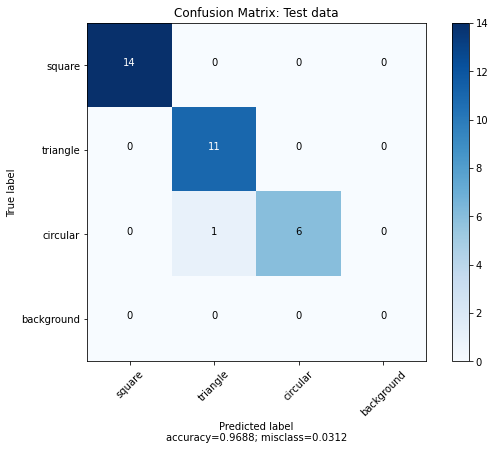

In [67]:
iter_dataloader = iter(test_dataloader)

X, Y = next(iter_dataloader)
preds = torch.argmax(modelObj.predict_step(X,0,0),dim=1)
print("Test accuracy {}%".format(np.mean(Y.numpy() == preds.numpy())*100))

confuTst = torchmetrics.functional.confusion_matrix(preds.detach().cpu(),Y.int().detach().cpu(), cfg.NUM_CLASSES)

plot.confusion_matrix(cm = confuTst.numpy(), 
                      normalize = False,
                      target_names = cfg.CLASSES,
                      title = "Confusion Matrix: Test data")

**Question:** Did data augmentation improve the model? \
**Question:** What do you think have the greatest impact on the performance, why? \